In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


In [45]:
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import os
from tokenization import FullTokenizer
from tqdm import tqdm_notebook

# Initialize session
# sess = tf.Session(),

# Params for bert model and tokenization
# bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
                            
max_seq_length = 64

In [3]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [4]:
len(word2idx)

445881

In [5]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [6]:
conditions = data.link_anchor.str.contains('#', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

In [7]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [8]:
data.shape

(2459381, 7)

In [9]:
# with open('../data/sample_doc2vec_data.pkl', 'rb') as f:
#     docs = pickle.load(f)

In [10]:
# with open('../data/sample_labels.pkl', 'rb') as f:
#     data = pickle.load(f)

In [11]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [12]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [13]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [14]:
id2idx = {value: key for key, value in idx2id.items()}

In [15]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [16]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [17]:
#window length actually 2 times this since from both sides
window_length = max_seq_length // 2

In [18]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

#lstm_input = []
#graph_input = []
# doc_input = []
#response = []
#not_in_graph = []

lstm_input_list = []
# corresponds to each candidate
graph_input_list = []

for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
    text = article['text']
    name = article['link_anchor']
    entity_id = article['target_wikidata']
    #Don't include actual entity text for now in context window since doing fixed length? 
    indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
    entity_idx = np.where(indices == 1)[0]
    if len(entity_idx):
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min() + window_length] 
#                   split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        context = ' '.join(context)
        #if word not in vocab, by default map to 1
#         context_word2idx = [word2idx.get(word, 1) for word in context]
        #storing list of candidates in knowledge graph
        kge_candidates = []
        
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        if not pd.isnull(article['candidates']):
            candidates_list = ast.literal_eval(article['candidates'])[:10]
            #can't choose actual entity as false 
            if entity_id in candidates_list:
                candidates_list.remove(entity_id)
            if len(candidates_list) > 0:
                for false_entity_id in candidates_list:
                    if false_entity_id in id2idx:
                        false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                        kge_candidates.append(false_graph_embed)
                    else:
                        pass
                        #not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            # this means that last index is always the true embedding
            kge_candidates.append(true_graph_embed)
            lstm_input_list.append(context)
            graph_input_list.append(np.array(kge_candidates))
        
        else:
            pass
            #not_in_graph.append(entity_id)
            
#lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
# graph_input = np.array(graph_input)
# # doc_input = np.array(doc_input)
# response = np.array(response)

In [19]:
# np.save("../data/model1/lstm_input.pkl", lstm_input)
# np.save("../data/model1/graph_input.pkl", graph_input)
# np.save("../data/model1/response.pkl", response)

In [19]:
lstm_input_list = np.array(lstm_input_list, dtype = object)[:, np.newaxis]
graph_input_list = np.array(graph_input_list)

In [ ]:
# np.save("../data/model1/lstm_input_list_bert.npy", lstm_input_list)
# np.save("../data/model1/graph_input_list_bert.npy", graph_input_list)

In [ ]:
# lstm_input_list = np.load("../data/model1/lstm_input_list_bert.npy", allow_pickle = True)
graph_input_list = np.load("../data/model1/graph_input_list.npy", allow_pickle = True)

In [10]:
# lstm_input = np.load("../data/model1/lstm_input.pkl.npy")
# graph_input = np.load("../data/model1/graph_input.pkl.npy")
# response = np.load("../data/model1/response.pkl.npy")

In [15]:
# np.random.seed(1)

# train_ind, test_ind = train_test_split(np.arange(len(response)))
# lstm_train = lstm_input[train_ind]
# lstm_test = lstm_input[test_ind]
# graph_train = graph_input[train_ind]
# graph_test = graph_input[test_ind]
# # doc_train = doc_input[train_ind]
# # doc_test = doc_input[test_ind]
# y_train = response[train_ind]
# y_test = response[test_ind]

# len(y_train), len(y_test)

(8844793, 2948265)

In [20]:
np.random.seed(1)

train_idx, test_idx = train_test_split(np.arange(len(lstm_input_list)), test_size=0.2)


In [21]:
len(train_idx)

1882452

In [22]:
len(test_idx)

470613

In [23]:
#indices = test_idx[:10]

In [24]:
def build_data(lstm_input_list, graph_input_list, indices):
    # construct lstm, graph set based on indices
    lstm_data = []
    graph_data = []
    response = []
    for ind in indices:
        lstm_inp = lstm_input_list[ind]
        graph_inp = graph_input_list[ind]
        for i, kge in enumerate(graph_inp):
            lstm_data.append(lstm_inp)
            graph_data.append(kge)
            if i == len(graph_inp)-1:
                response.append(1)
            else:
                response.append(0)
#     lstm_data = np.array(lstm_data)
#     lstm_data = pad_sequences(lstm_data, maxlen = window_length * 2, padding = 'post')
    graph_data = np.array(graph_data)
    response = np.array(response)

    return lstm_data, graph_data, response

In [25]:
lstm_train, graph_train, y_train = build_data(lstm_input_list, graph_input_list, train_idx)
lstm_test, graph_test, y_test = build_data(lstm_input_list, graph_input_list, test_idx)

In [26]:
np.save("../data/model1/bert_graph_train.npy", graph_train, allow_pickle = True)
np.save("../data/model1/bert_graph_test.npy", graph_test, allow_pickle = True)

In [ ]:
graph_train = np.load("../data/model1/bert_graph_train.npy")
graph_test = np.load("../data/model1/bert_graph_test.npy")

In [29]:

class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module(bert_layer):
    """Get the vocab file and casing info from the Hub module."""
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = FullTokenizer(vocab_file, do_lower_case)
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_layer)

# Convert data to InputExample format
train_examples = convert_text_to_examples(lstm_train, y_train)
test_examples = convert_text_to_examples(lstm_test, y_test)

# # Convert to features
# (train_input_ids, train_input_masks, train_segment_ids, train_labels 
# ) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
# (test_input_ids, test_input_masks, test_segment_ids, test_labels
# ) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [34]:
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples[:5000000], max_seq_length=max_seq_length)

In [36]:
np.save('../data/model1/bert_train_input_ids.npy', train_input_ids, True)
np.save('../data/model1/bert_train_input_masks.npy', train_input_masks, True)
np.save('../data/model1/bert_train_segment_ids.npy', train_segment_ids, True)
np.save('../data/model1/bert_train_labels.npy', train_labels, True)

In [39]:
(valid_input_ids, valid_input_masks, valid_segment_ids, valid_labels 
) = convert_examples_to_features(tokenizer, train_examples[5000000:], max_seq_length=max_seq_length)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
np.save('../data/model1/bert_valid_input_ids.npy', valid_input_ids, True)
np.save('../data/model1/bert_valid_input_masks.npy', valid_input_masks, True)
np.save('../data/model1/bert_valid_segment_ids.npy', valid_segment_ids, True)
np.save('../data/model1/bert_valid_labels.npy', valid_labels, True)

In [37]:
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [38]:
np.save('../data/model1/bert_test_input_ids.npy', test_input_ids, True)
np.save('../data/model1/bert_test_input_masks.npy', test_input_masks, True)
np.save('../data/model1/bert_test_segment_ids.npy', test_segment_ids, True)
np.save('../data/model1/bert_test_labels.npy', test_labels, True)

In [27]:
train_input_ids = np.load('../data/model1/bert_train_input_ids.npy')
train_input_masks = np.load('../data/model1/bert_train_input_masks.npy')
train_segment_ids = np.load('../data/model1/bert_train_segment_ids.npy')
train_labels = np.load('../data/model1/bert_train_labels.npy')

In [28]:
valid_input_ids = np.load('../data/model1/bert_valid_input_ids.npy')
valid_input_masks = np.load('../data/model1/bert_valid_input_masks.npy')
valid_segment_ids = np.load('../data/model1/bert_valid_segment_ids.npy')
valid_labels = np.load('../data/model1/bert_valid_labels.npy')

In [29]:
test_input_ids = np.load('../data/model1/bert_test_input_ids.npy')
test_input_masks = np.load('../data/model1/bert_test_input_masks.npy')
test_segment_ids = np.load('../data/model1/bert_test_segment_ids.npy')
test_labels = np.load('../data/model1/bert_test_labels.npy')

In [30]:
#only did train and validation because previously kernel died, so split it
X_train_input_ids = np.concatenate([train_input_ids, valid_input_ids])
X_train_input_masks = np.concatenate([train_input_masks, valid_input_masks])
X_train_segment_ids = np.concatenate([train_segment_ids, valid_segment_ids])
y_train = np.concatenate([train_labels, valid_labels])

In [31]:
# weights = class_weight.compute_class_weight('balanced',
#                                             [0, 1],
#                                             y_train)

TypeError: unhashable type: 'numpy.ndarray'

In [59]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

input_graph = tf.keras.layers.Input(shape=(graph_train.shape[1],), dtype=tf.float32,
                                       name="input_graph")

w = tf.keras.layers.Concatenate()([pooled_output, input_graph])


w = tf.keras.layers.Dense(256, activation = 'relu')(w)
w = tf.keras.layers.Dropout(0.2)(w)
out = tf.keras.layers.Dense(1, activation = 'sigmoid')(w)
model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids, input_graph], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [60]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([X_train_input_ids, X_train_input_masks, X_train_segment_ids, graph_train], y_train,
          batch_size = 8192, epochs = 4, validation_split = 0.2)

W1116 18:45:13.935020 139902948403008 deprecation.py:323] From /home/matteo/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7490784 samples, validate on 1872697 samples
Epoch 1/4


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[524288,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node keras_layer_1_11/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_model/StatefulPartitionedCall/encoder/layer_0/self_attention/key/einsum/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[dropout_5/cond/then/_205/dropout/Cast/_34]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[524288,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node keras_layer_1_11/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_model/StatefulPartitionedCall/encoder/layer_0/self_attention/key/einsum/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_97681]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


In [96]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8662181277972191

In [97]:
cm = confusion_matrix(y_test, y_test_pred)

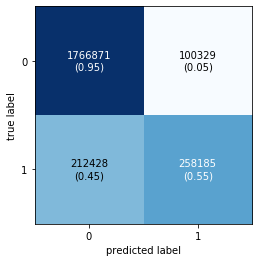

In [98]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [99]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8992317949581741

In [100]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

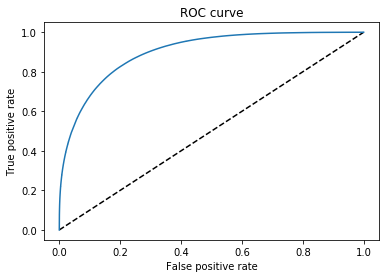

In [101]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [47]:
# see prediction score on candidate list

# find cutoff
# offset of where the true index is
cutoffs = [0]
for ind in test_idx:
    graph_inp = graph_input_list[ind]
    cutoffs.append(cutoffs[-1] + len(graph_inp))

In [174]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

[0.01729989] [0.02396834]
[0.32298976] [0.3544377]
[0.18044725] [0.2968958]
[0.28315234] [0.28633875]
[0.08612305] [0.31351438]
[0.55070865] [0.6028807]
[0.35431233] [0.5716927]
[0.19054782] [0.37446225]
[0.13249263] [0.54841304]
[0.32559013] [0.58030134]
[0.28484526] [0.83727324]
[0.2629851] [0.40478578]
[0.08219287] [0.5176184]
[0.12858799] [0.1606648]
[0.50938183] [0.73565733]
[0.44300902] [0.5855285]
[0.363913] [0.4488064]
[0.7684406] [0.87551075]
[0.54154724] [0.5485639]
[0.20312539] [0.35756332]
[0.19594243] [0.20610839]
[0.5074946] [0.56297266]
[0.2570477] [0.257521]
[0.23742947] [0.64808106]
[0.0569424] [0.30480427]
[0.2340967] [0.2588004]
[0.12902698] [0.67055833]
[0.38749236] [0.73769647]
[0.06655031] [0.56181115]
[0.40871948] [0.44199568]
[0.18334278] [0.19862235]
[0.39908248] [0.5068826]
[0.33775038] [0.42255723]
[0.27888238] [0.28611928]
[0.72619474] [0.7747072]
[0.48645335] [0.6405939]
[0.05742076] [0.16479048]
[0.03145665] [0.65452254]
[0.5342952] [0.7593354]
[0.18748692

In [176]:
candidate_test_acc

0.749747669528891

In [177]:
half_size = round(len(test_idx)/2)
abst_val_idx, abst_test_idx = test_idx[:half_size], test_idx[half_size:]
abst_val_cutoffs, abst_test_cutoffs = cutoffs[:half_size+1], cutoffs[half_size:]

In [48]:
num_tr = 20
thresholds = 1./num_tr * np.arange(num_tr)

In [179]:
recall_with_abstain = []
acc_after_abstain = []
abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    recall = .0
    acc = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx]
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            if max_prob == probs[-1]:
                if np.random.randint(sum(probs == probs[-1])) == 0:
                    acc += 1
    
    # only count non abst cases
    recall = acc / abst_val_count
    acc /= (abst_val_count - abst)
    
    recall_with_abstain.append(recall)
    acc_after_abstain.append(acc)
    abstain_rate.append(abst/abst_val_count)

Text(0, 0.5, 'Recall')

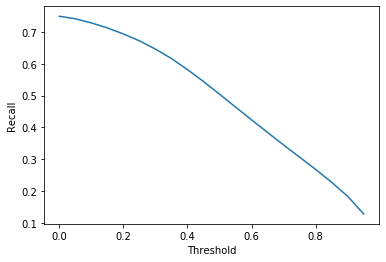

In [180]:
plt.plot(thresholds, recall_with_abstain)
plt.xlabel("Threshold")
plt.ylabel("Recall")

Text(0, 0.5, 'Precision (excluding abstained)')

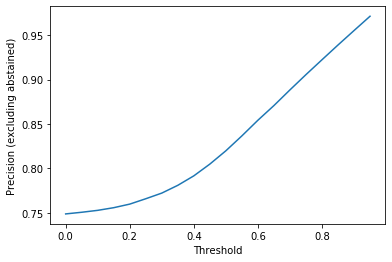

In [181]:
plt.plot(thresholds, acc_after_abstain)
plt.xlabel("Threshold")
plt.ylabel("Precision (excluding abstained)")

Text(0, 0.5, 'Precision (excluding abstained)')

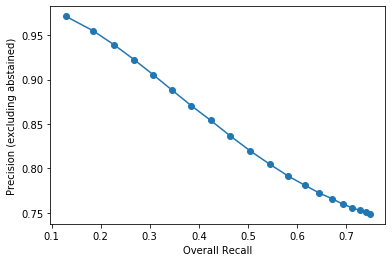

In [182]:
plt.plot(recall_with_abstain, acc_after_abstain, 'o-')
plt.xlabel("Overall Recall")
plt.ylabel("Precision (excluding abstained)")

In [226]:
# without the true
false_positive_rate = []
false_abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    fpr = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx-1]
        if len(probs) == 0:
            continue
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            fpr += 1
    
    # only count non abst cases
    fpr /= abst_val_count
    abst /= abst_val_count
    
    false_positive_rate.append(fpr)
    false_abstain_rate.append(abst)

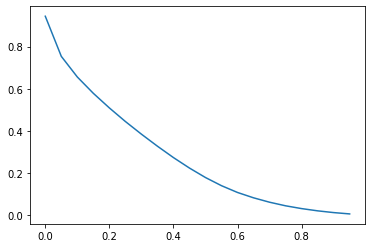

In [227]:
plt.plot(thresholds, false_positive_rate)

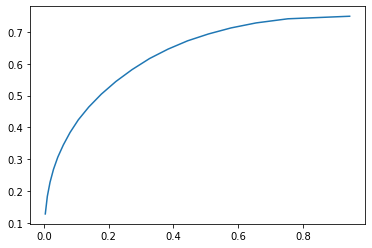

In [230]:
plt.plot(false_positive_rate, recall_with_abstain)

In [183]:
thresholds[3]

0.15000000000000002

In [184]:
recall_with_abstain[0]

0.7487781867015716

In [185]:
acc_after_abstain[0]

0.7487781867015716

In [186]:
recall_with_abstain[1]

0.740792839961582

In [187]:
acc_after_abstain[1]

0.7506373266729826

In [188]:
abstain_rate[3]

0.05780133103278284

In [221]:
chosen_tr = thresholds[6]
abst_test_count = len(abst_test_cutoffs) - 1
# abstain below the threshold

recall = .0
acc = .0
abst = .0
for start_idx, end_idx in zip(abst_test_cutoffs, abst_test_cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    max_prob = max(probs)
    if max_prob <= chosen_tr:
        abst += 1
    else:
        if max_prob == probs[-1]:
            if np.random.randint(sum(probs == probs[-1])) == 0:
                acc += 1

# only count non abst cases
recall = acc / abst_test_count
acc /= (abst_test_count - abst)
abst /= abst_test_count

In [222]:
recall

0.6474435524655026

In [223]:
acc

0.7724382700400547

In [224]:
abst

0.16181839044312324

In [90]:
inp1 = Input(shape = (lstm_train.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_train.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = out1
w = Dropout(0.2)(w)
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 20, 100)           44588100  
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total para

In [92]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/4
7490784/7490784 [==============================] - 114s 15us/step - loss: 0.4932 - acc: 0.7989 - val_loss: 0.4857 - val_acc: 0.7994
Epoch 2/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4834 - acc: 0.7994 - val_loss: 0.4835 - val_acc: 0.7997
Epoch 3/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4773 - acc: 0.7997 - val_loss: 0.4843 - val_acc: 0.7997
Epoch 4/4
7490784/7490784 [==============================] - 112s 15us/step - loss: 0.4717 - acc: 0.7999 - val_loss: 0.4855 - val_acc: 0.7998


In [93]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without knowledge graph embedding

y_test_pred_prob = model.predict([lstm_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.7994843898977377

In [94]:
cm = confusion_matrix(y_test, y_test_pred)

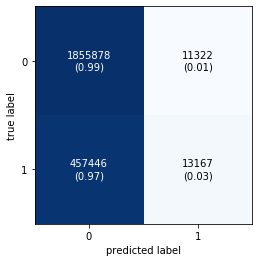

In [95]:
plot_confusion_matrix(cm, show_normed = True);

In [96]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [97]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.6360648844168897

Text(0.5, 1.0, 'ROC curve')

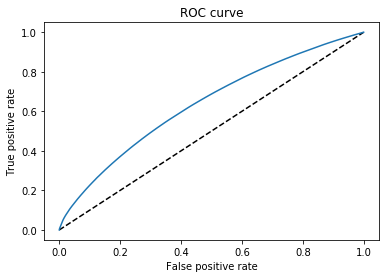

In [98]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [99]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

In [100]:
candidate_test_acc

0.3558677724584744

In [28]:
graph_input.shape

(11793058, 250)

In [62]:
inp2 = Input(shape = (graph_train.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
w = inp2
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 64,513
Trainable params: 64,513
Non-trainable params: 0
_________________________________________________________________


In [63]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([graph_train], y_train, batch_size = 8192, epochs = 30, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/30
7490784/7490784 [==============================] - 9s 1us/step - loss: 0.4158 - acc: 0.8232 - val_loss: 0.3836 - val_acc: 0.8348
Epoch 2/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3851 - acc: 0.8342 - val_loss: 0.3719 - val_acc: 0.8394
Epoch 3/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3779 - acc: 0.8369 - val_loss: 0.3670 - val_acc: 0.8411
Epoch 4/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3738 - acc: 0.8385 - val_loss: 0.3632 - val_acc: 0.8430
Epoch 5/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3709 - acc: 0.8396 - val_loss: 0.3607 - val_acc: 0.8440
Epoch 6/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3688 - acc: 0.8405 - val_loss: 0.3592 - val_acc: 0.8444
Epoch 7/30
7490784/7490784 [==============================] - 8s 1us/step - loss: 0.3671 - acc: 0.8412 - v

In [82]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without knowledge graph embedding

y_test_pred_prob = model.predict([graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8503229300204935

In [83]:
cm = confusion_matrix(y_test, y_test_pred)

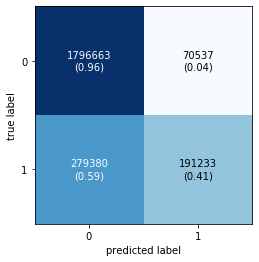

In [84]:
plot_confusion_matrix(cm, show_normed = True);

In [85]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [86]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8621347084016182

Text(0.5, 1.0, 'ROC curve')

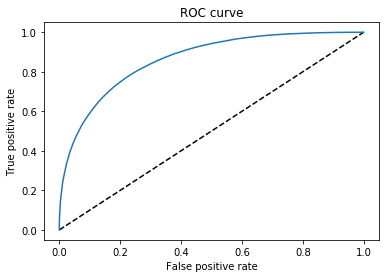

In [87]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [88]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

[0.10663849] [0.21659997]
[0.15073198] [0.20447108]
[0.02454388] [0.333121]
[0.20760688] [0.5531492]
[0.27174062] [0.31035823]
[0.2743048] [0.52534866]
[0.04032218] [0.24748713]
[0.30647624] [0.393618]
[0.28649652] [0.42994094]
[0.24155119] [0.43789852]
[0.21499088] [0.29324704]
[0.22514299] [0.43782756]
[0.3787086] [0.5718919]
[0.1199792] [0.36397743]
[0.11733639] [0.16777924]
[0.11471987] [0.44338456]
[0.27232975] [0.593252]
[0.11515388] [0.3145296]
[0.28729564] [0.7646096]
[0.14040726] [0.19897676]
[0.30483726] [0.49834338]
[0.18419927] [0.3489733]
[0.05136034] [0.26318687]
[0.10435221] [0.18540221]
[0.12763667] [0.42356098]
[0.09033132] [0.71793526]
[0.30643654] [0.43717554]
[0.10352471] [0.26613644]
[0.19912037] [0.22046936]
[0.18573564] [0.28898227]
[0.11680326] [0.1347022]
[0.3960596] [0.43939933]
[0.20443588] [0.2801205]
[0.17167333] [0.22688803]
[0.22127089] [0.32030404]
[0.11636564] [0.39895278]
[0.36752796] [0.66682017]
[0.15450078] [0.6628461]
[0.6533886] [0.82122916]
[0.16

In [89]:
candidate_test_acc

0.6894943403603385

In [40]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])

# perfomance without word embedding

y_test_pred = model.predict([graph_test])

y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8411214731375911

In [41]:
cm = confusion_matrix(y_test, y_test_pred)

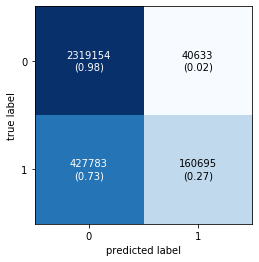

In [42]:
plot_confusion_matrix(cm, show_normed = True);

In [ ]:
# retrain new model

In [107]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = concatenate([out1, inp2])
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 20, 100)      44588100    input_19[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 128)          117248      embedding_10[0][0]               
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [108]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_11/acc/Mean_1/_1673]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/Adam/mul_16}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [ ]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

In [ ]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [96]:
# inp1 = Input(shape = (lstm_input.shape[1], ))
# inp2 = Input(shape = (graph_input.shape[1], ))
# # inp3 = Input(shape = (doc_input.shape[1], ))
# embed = Embedding(output_dim=128, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
# out1 = LSTM(128)(embed)
# w = concatenate([out1, inp2])
# w = Dense(128, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(64, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# w = Dense(32, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# out = Dense(1, activation = 'sigmoid')(w)
# model = Model(inputs=[inp1, inp2], outputs=out)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 20, 128)      57072768    input_15[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          131584      embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [97]:
# # model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
# model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7075834 samples, validate on 1768959 samples
Epoch 1/4
7075834/7075834 [==============================] - 248s 35us/step - loss: 0.4011 - acc: 0.8251 - val_loss: 0.3412 - val_acc: 0.8467
Epoch 2/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3334 - acc: 0.8494 - val_loss: 0.3199 - val_acc: 0.8555
Epoch 3/4
7075834/7075834 [==============================] - 244s 35us/step - loss: 0.3016 - acc: 0.8619 - val_loss: 0.3136 - val_acc: 0.8583
Epoch 4/4
7075834/7075834 [==============================] - 245s 35us/step - loss: 0.2769 - acc: 0.8727 - val_loss: 0.3205 - val_acc: 0.8580


In [98]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8578384236152449

In [100]:
cm = confusion_matrix(y_test, y_test_pred)

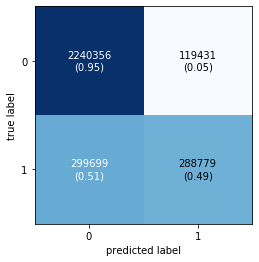

In [101]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [102]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8862756502902215

In [103]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

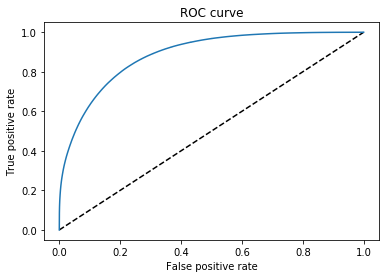

In [104]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
def compute_abstain_threshold()

In [72]:
print('hi')

hi


In [ ]:
def 

In [40]:
# model.save('../data/model1/model.h5')

# np.save("../data/model1/lstm_train", lstm_train)
# np.save("../data/model1/lstm_iest", lstm_test)

# np.save("../data/model1/graph_train", graph_train)
# np.save("../data/model1/graph_test", graph_test)

# np.save("../data/model1/y_train", y_train)
# np.save("../data/model1/y_test", y_test)

In [ ]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);